# DataLoader and Processing

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision.transforms as transforms
import torchvision.utils
from torchvision.utils import make_grid

import torchvision.datasets

import matplotlib.pyplot as plt 
plt.rcParams["figure.figsize"] = (10,6)

from tqdm import tqdm 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [ ]:
batch_size = 128 # Images per batch

# Resize to 32x32 for easier upsampling/downsampling
mytransform = transforms.Compose([transforms.Resize(32),
                                  transforms.ToTensor(),
                                 transforms.Normalize((.5), (.5))]) # normalize between [-1, 1] with tanh activation

mnist_train = torchvision.datasets.MNIST(root='.', download=True, transform=mytransform)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
dataloader = DataLoader(dataset=mnist_train, 
                         batch_size=batch_size,
                         shuffle=True)  

In [ ]:
# plot some images
real_batch, real_labels = next(iter(dataloader))

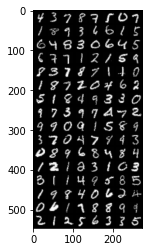

In [ ]:
plt.imshow(transforms.ToPILImage()(make_grid(real_batch)))


## Generator

In [ ]:
def get_upscaling_block(channels_in, channels_out, kernel, stride, padding, last_layer=False):
    '''
    Each transpose conv will be followed by BatchNorm and ReLU, 
    except the last block (which is only followed by tanh)
    '''
    
    if last_layer:
        
        ###################
        #                 #
        # YOUR CODE HERE  #
        #                 #
        ###################
        model=nn.Sequential(nn.ConvTranspose2d(channels_in,channels_out,kernel,stride=stride,padding=padding),
                            nn.Tanh())
    else:
        ###################
        #                 #
        # YOUR CODE HERE  #
        #                 #
        ###################
        model=nn.Sequential(nn.ConvTranspose2d(channels_in,channels_out,kernel,stride=stride,padding=padding),
                            nn.BatchNorm2d(channels_out),
                            nn.LeakyReLU(0.2,inplace=True))
    return model


class Generator(nn.Module):
    def __init__(self, nz, ngf, nchannels=1):
        '''
        nz: The latent size (100 in our case)
        ngf: The channel-size before the last layer (32 our case)
        '''
        super().__init__()
        
        ###################
        #                 #
        # YOUR CODE HERE  #
        #                 #
        
        self.model = nn.Sequential(get_upscaling_block(nz, ngf * 4, 4, 1, 0),
                                   get_upscaling_block(ngf * 4, ngf * 2, 4, 2, 1),
                                   get_upscaling_block(ngf * 2, ngf , 4, 2, 1),
                                   get_upscaling_block(ngf , nchannels, 4, 2, 1,last_layer=True))   
        
        ###################
        
    def forward(self, z):
        x = z.unsqueeze(2).unsqueeze(2) # give spatial dimensions to z
        return self.model(x)

## Discriminator

In [ ]:
def get_downscaling_block(channels_in, channels_out, kernel, stride, padding, use_batch_norm=True, is_last=False):
    
    if is_last:
        ###################
        #                 #
        # YOUR CODE HERE  #
        #                 #
        ###################
        model=nn.Sequential(nn.Conv2d(channels_in,channels_out,kernel,stride=stride,padding=padding),
                            nn.Sigmoid())
    
    elif not use_batch_norm:
        ###################
        #                 #
        # YOUR CODE HERE  #
        #                 #
        ###################
        model=nn.Sequential(nn.Conv2d(channels_in,channels_out,kernel,stride=stride,padding=padding),
                            nn.LeakyReLU(0.2, inplace=True))
    
    
    else:
        ###################
        #                 #
        # YOUR CODE HERE  #
        #                 #
        ###################
        model=nn.Sequential(nn.Conv2d(channels_in,channels_out,kernel,stride=stride,padding=padding),
                            nn.BatchNorm2d(channels_out),
                            nn.LeakyReLU(0.2, inplace=True))
    
    return model


class Discriminator(nn.Module):
    def __init__(self, ndf, nchannels=1):
        super().__init__()
        
        ###################
        #                 #
        # YOUR CODE HERE  #
        
        self.model = nn.Sequential(get_downscaling_block(nchannels,ndf,4,2,1),
                                   get_downscaling_block(ndf,ndf*2,4,2,1),
                                   get_downscaling_block(ndf*2,ndf*4,4,2,1),
                                   get_downscaling_block(ndf*4,1,4,2,0,is_last=True))
        
        #                 #
        ###################

    def forward(self, x):
        return self.model(x).squeeze(1).squeeze(1) # remove spatial dimensions

# CGAN

In [ ]:
# GENERATOR

'''
The conditional generator needs the label information as well as the latent vector. We will combine the latent vector and the class information in the following way:

- The class information for the generator will be represented as a one-hot vector sized `[batch_size, 10]` (since there are 10 classes in MNIST)
- The latent vector for the generator will still be sized `[batch_size, nz]`

1. Transform both of these modalities into 'images' (by adding dimensions)
2. Like before, apply the first upscaling block to both of these 'images'. We will now have 2 separate blocks sized 

'''

class ConditionalGenerator(nn.Module):
    def __init__(self, nz, nc, ngf, nchannels=1):
        super().__init__()
        
        self.upscaling_z = get_upscaling_block(nz, ngf*8, 4, 1, 0)
        self.upscaling_c = get_upscaling_block(nc, ngf*8, 4, 1, 0)
        
        ###################
        #                 #
        # YOUR CODE HERE  #
        #                 #
        self.rest_model = nn.Sequential(get_upscaling_block(ngf * 16, ngf * 8, 4, 2, 1),
                                   get_upscaling_block(ngf * 8, ngf * 4, 4, 2, 1),
                                   get_upscaling_block(ngf * 4, nchannels , 4, 2, 1,last_layer=True))
        
        ###################
        
    def forward(self, x, y):
        x = x.unsqueeze(2).unsqueeze(2)
        y = y.unsqueeze(2).unsqueeze(2)
        
        ###################
        #                 #
        # YOUR CODE HERE  #
        #                 #
        ###################
        x=torch.cat([self.upscaling_z(x),self.upscaling_c(y)],dim=1)
        return self.rest_model(x)

In [ ]:
# Discriminator

'''
The conditional discriminator needs the label information as well as the latent vector. We will combine the latent vector and the class information in the following way:

- The class information for the discriminator will be represented as a one-hot vector sized `[batch_size, 10]` (since there are 10 classes in MNIST)
- The latent vector for the generator will still be sized `[batch_size, nz]`

1. Transform both of these modalities into 'images' (by adding dimensions)
2. Like before, apply the first upscaling block to both of these 'images'. We will now have 2 separate blocks sized 

'''
    
class ConditionalDiscriminator(nn.Module):
    def __init__(self, ndf, nc, nchannels=1):
        super().__init__()
        self.downscale_x = get_downscaling_block(nchannels, ndf*2, 4, 2, 1, use_batch_norm=False)
        self.downscale_y = get_downscaling_block(nc, ndf*2, 4, 2, 1, use_batch_norm=False)
        
        ###################
        #                 #
        # YOUR CODE HERE  #
        
        self.rest = nn.Sequential(get_downscaling_block(ndf*4,ndf*8,4,2,1),
                                  get_downscaling_block(ndf*8,ndf*16,4,2,1),
                                  get_downscaling_block(ndf*16,nchannels,4,1,0,is_last=True))
        
        #                 #
        ###################
        
    def forward(self, x, y):
        ###################
        #                 #
        # YOUR CODE HERE  #
        #                 #
        ###################
        y = y.unsqueeze(2).unsqueeze(2).repeat(1,1,x.shape[2], x.shape[3])
        x=self.downscale_x(x)
        y=self.downscale_y(y)
        x=torch.cat([x,y],dim=1)
        return self.rest(x).squeeze(1).squeeze(1) # remove spatial dimensions

# Training

In [ ]:
def sample_z(batch_size, nz):
    return torch.randn(batch_size, nz, device=device)

# this is for the real ground-truth label
def get_labels_one(batch_size):
    r = torch.ones(batch_size, 1)
    return r.to(device)

# this is for the generated ground-truth label
def get_labels_zero(batch_size):
    r = torch.zeros(batch_size, 1) 
    return r.to(device)


# To initialize the weights of a GAN, the DCGAN paper found that best results are obtained
# with Gaussian initialization with mean=0; std=0.02
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        

# for visualization
to_pil = transforms.ToPILImage()
renorm = transforms.Normalize((-1.), (2.))

In [ ]:

nz = 100
ndf = 32
ngf = 32
nchannels= 1 
lr_d = 0.0002
lr_g = 0.0005
beta1= 0.5
display_freq = 200

nc= 10

netD = ConditionalDiscriminator(ndf, nc, nchannels=1).to(device)
netG = ConditionalGenerator(nz, nc, ngf).to(device)
        
netG.apply(weights_init)
netD.apply(weights_init)

g_opt = torch.optim.Adam(netG.parameters(), lr=lr_g, betas=(beta1, 0.999))
d_opt = torch.optim.Adam(netD.parameters(), lr=lr_d, betas=(beta1, 0.999))

criterion=torch.nn.BCELoss()

In [ ]:
# Conditional Discriminator Sanity Checking

cD = ConditionalDiscriminator(ndf=32, nc=10, nchannels=1)

assert cD(real_batch, F.one_hot(real_labels).float()).shape == (real_batch.shape[0], 1)

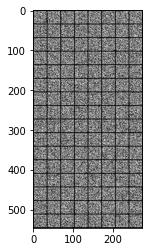

In [ ]:
z = torch.randn(batch_size, nz)
y = F.one_hot(real_labels).float()

cG = ConditionalGenerator(nz=nz, ngf=16, nc=10)
x_fake = cG(z, y)
plt.imshow(transforms.ToPILImage()(make_grid(x_fake, nrow=8)))

it: 0; g_loss: 1.170093297958374; d_loss: 0.39720532298088074; avg_real_score: 0.6105360984802246; avg_fake_score: 0.2550020217895508: : 0it [00:00, ?it/s]

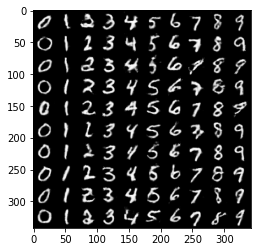

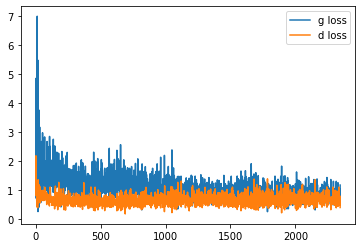

it: 200; g_loss: 1.6690232753753662; d_loss: 0.5572607517242432; avg_real_score: 0.3652157187461853; avg_fake_score: 0.0900939553976059: : 200it [01:19,  2.54it/s]

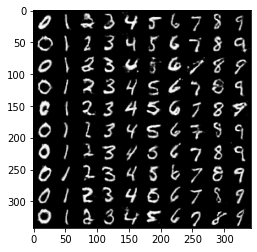

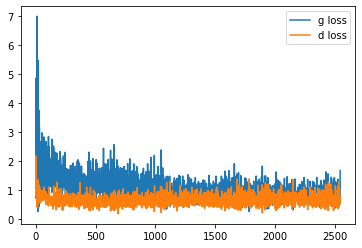

it: 400; g_loss: 0.733345627784729; d_loss: 0.760991632938385; avg_real_score: 0.33861321210861206; avg_fake_score: 0.3454816937446594: : 400it [02:38,  2.55it/s]

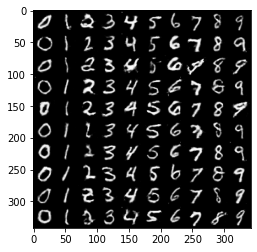

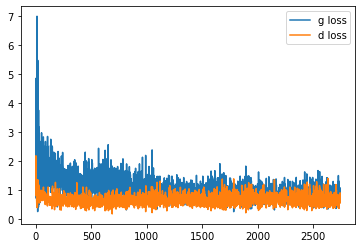

it: 468; g_loss: 0.8839563131332397; d_loss: 0.8554052114486694; avg_real_score: 0.2887560725212097; avg_fake_score: 0.3634001612663269: : 469it [03:05,  2.52it/s]
it: 469; g_loss: 0.7800438404083252; d_loss: 0.624154806137085; avg_real_score: 0.46536552906036377; avg_fake_score: 0.3747562766075134: : 0it [00:00, ?it/s]

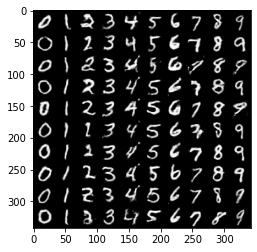

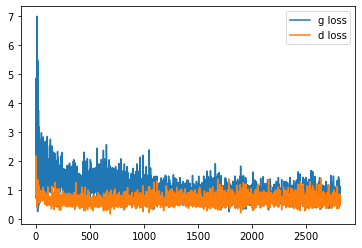

it: 669; g_loss: 0.9426532983779907; d_loss: 0.562579870223999; avg_real_score: 0.5006006956100464; avg_fake_score: 0.34553447365760803: : 200it [01:19,  2.54it/s] 

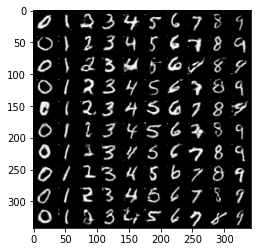

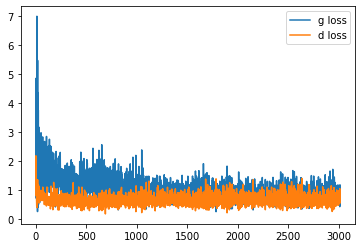

it: 869; g_loss: 0.8130351305007935; d_loss: 0.6272950172424316; avg_real_score: 0.4327036738395691; avg_fake_score: 0.335213840007782: : 400it [02:39,  2.53it/s] 

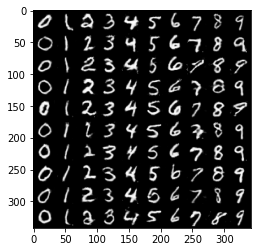

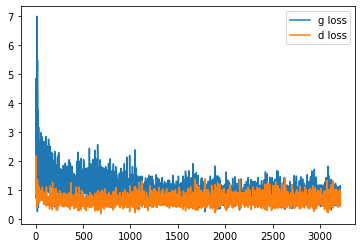

it: 937; g_loss: 0.992626428604126; d_loss: 0.546099066734314; avg_real_score: 0.6059420108795166; avg_fake_score: 0.44229888916015625: : 469it [03:07,  2.50it/s]
it: 938; g_loss: 0.9815188646316528; d_loss: 0.5319957733154297; avg_real_score: 0.5813726782798767; avg_fake_score: 0.40346670150756836: : 0it [00:00, ?it/s]

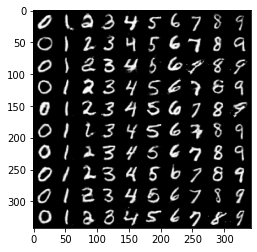

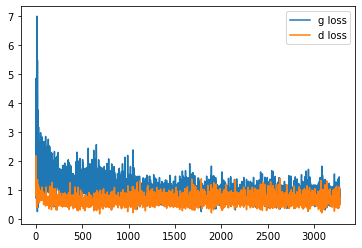

it: 1138; g_loss: 0.6745826005935669; d_loss: 1.12030029296875; avg_real_score: 0.1797044277191162; avg_fake_score: 0.38955622911453247: : 200it [01:20,  2.52it/s] 

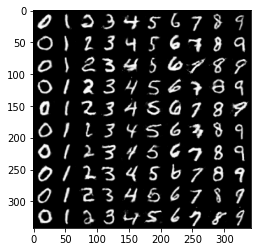

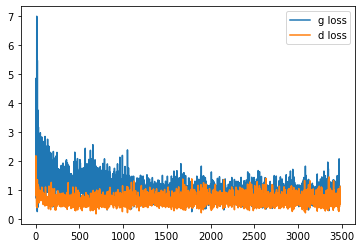

it: 1338; g_loss: 0.5673952698707581; d_loss: 1.0143840312957764; avg_real_score: 0.7587041854858398; avg_fake_score: 0.8186589479446411: : 400it [02:40,  2.51it/s] 

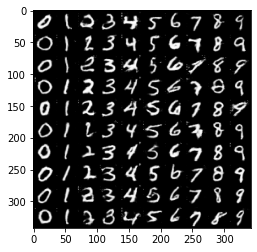

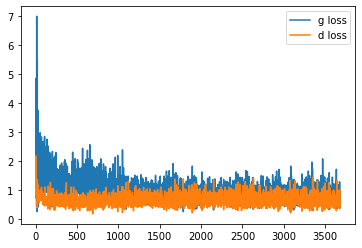

it: 1406; g_loss: 0.6302417516708374; d_loss: 0.7925760746002197; avg_real_score: 0.4987565875053406; avg_fake_score: 0.5867361426353455: : 469it [03:07,  2.50it/s]
it: 1407; g_loss: 0.651542067527771; d_loss: 0.8281161785125732; avg_real_score: 0.4080038070678711; avg_fake_score: 0.5266468524932861: : 0it [00:00, ?it/s]

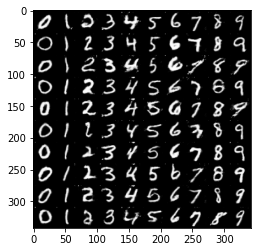

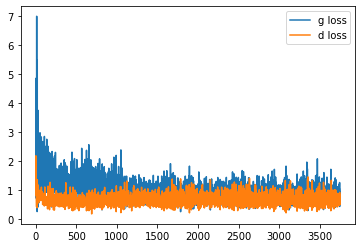

it: 1607; g_loss: 1.1144113540649414; d_loss: 0.5055795311927795; avg_real_score: 0.5118355751037598; avg_fake_score: 0.28233519196510315: : 200it [01:21,  2.50it/s]

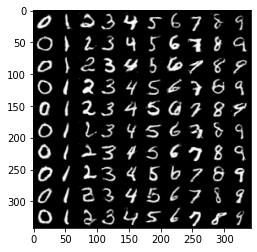

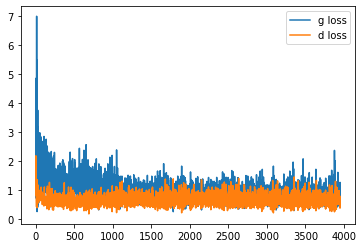

it: 1807; g_loss: 1.084088683128357; d_loss: 0.7672194242477417; avg_real_score: 0.2636907696723938; avg_fake_score: 0.17178206145763397: : 400it [02:41,  2.49it/s]

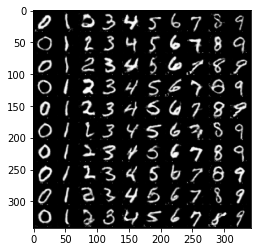

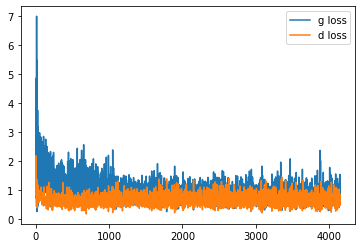

it: 1875; g_loss: 1.082646131515503; d_loss: 0.48796194791793823; avg_real_score: 0.6292213797569275; avg_fake_score: 0.3987976908683777: : 469it [03:09,  2.48it/s]
it: 1876; g_loss: 1.522567868232727; d_loss: 0.38680046796798706; avg_real_score: 0.551934003829956; avg_fake_score: 0.16090042889118195: : 0it [00:00, ?it/s]

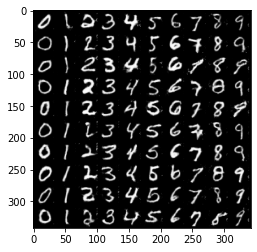

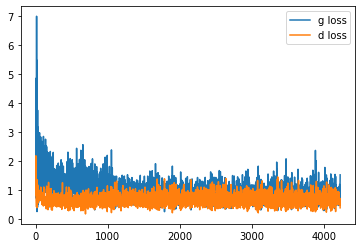

it: 2076; g_loss: 1.5591678619384766; d_loss: 0.3401486873626709; avg_real_score: 0.5905236005783081; avg_fake_score: 0.14015240967273712: : 200it [01:21,  2.48it/s]

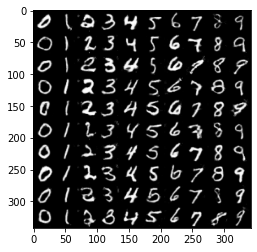

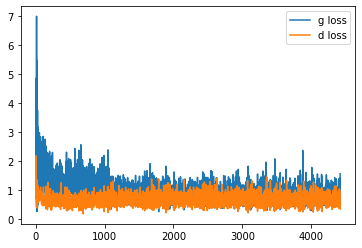

it: 2276; g_loss: 0.8950492143630981; d_loss: 0.4366230070590973; avg_real_score: 0.6864036917686462; avg_fake_score: 0.38694605231285095: : 400it [02:42,  2.47it/s]

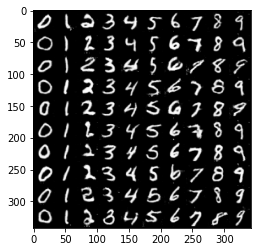

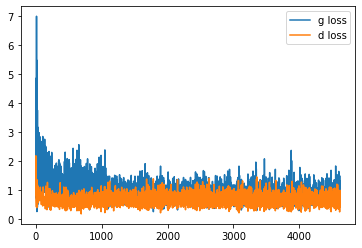

it: 2344; g_loss: 0.5801326632499695; d_loss: 0.757809579372406; avg_real_score: 0.6278873682022095; avg_fake_score: 0.6449510455131531: : 469it [03:10,  2.46it/s]
it: 2345; g_loss: 1.213807463645935; d_loss: 0.4126061797142029; avg_real_score: 0.8656536340713501; avg_fake_score: 0.4899970293045044: : 0it [00:00, ?it/s]

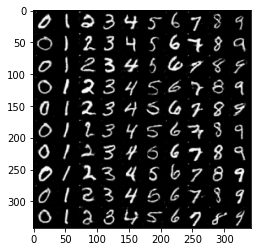

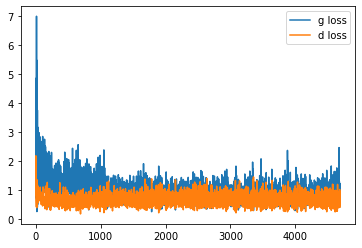

it: 2545; g_loss: 0.767848014831543; d_loss: 1.0078740119934082; avg_real_score: 0.25841763615608215; avg_fake_score: 0.4611004590988159: : 200it [01:21,  2.50it/s]

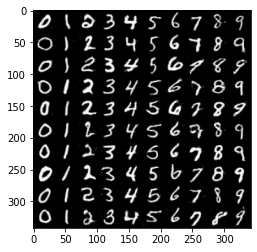

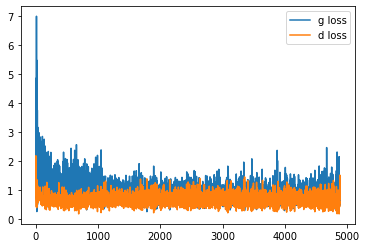

it: 2745; g_loss: 0.6874610185623169; d_loss: 0.7889440655708313; avg_real_score: 0.6182993650436401; avg_fake_score: 0.6608420610427856: : 400it [02:42,  2.47it/s]

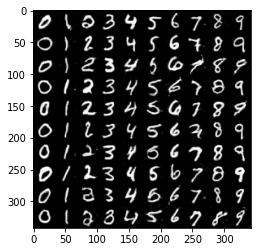

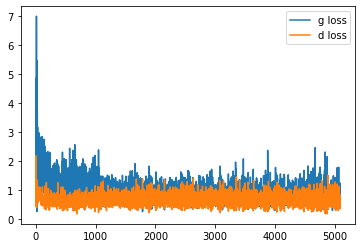

it: 2813; g_loss: 0.9417880773544312; d_loss: 0.53233402967453; avg_real_score: 0.8345046043395996; avg_fake_score: 0.5824716091156006: : 469it [03:10,  2.46it/s]
it: 2814; g_loss: 0.803435206413269; d_loss: 1.015737533569336; avg_real_score: 0.20251958072185516; avg_fake_score: 0.34341639280319214: : 0it [00:00, ?it/s]

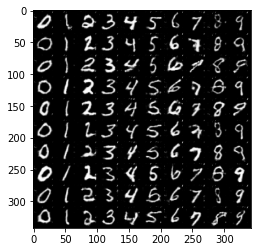

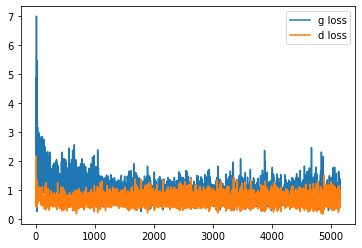

it: 3014; g_loss: 0.8752748966217041; d_loss: 0.732154369354248; avg_real_score: 0.35550469160079956; avg_fake_score: 0.3434520363807678: : 200it [01:22,  2.49it/s]

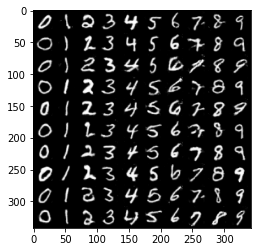

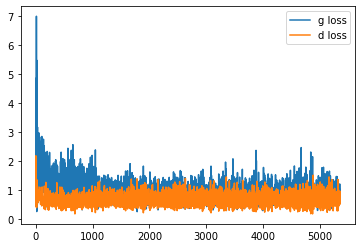

it: 3214; g_loss: 0.992018461227417; d_loss: 0.6221611499786377; avg_real_score: 0.7124255895614624; avg_fake_score: 0.5901892185211182: : 400it [02:43,  2.47it/s]   

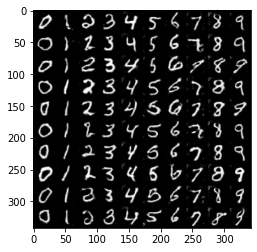

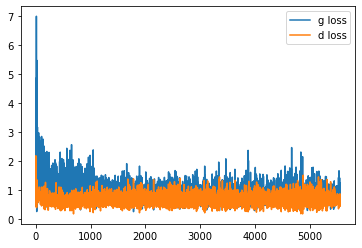

it: 3282; g_loss: 0.9473854899406433; d_loss: 0.5800082683563232; avg_real_score: 0.4783449172973633; avg_fake_score: 0.33504170179367065: : 469it [03:11,  2.44it/s]
it: 3283; g_loss: 0.7443982362747192; d_loss: 0.7292428016662598; avg_real_score: 0.5800520777702332; avg_fake_score: 0.5911864638328552: : 0it [00:00, ?it/s]

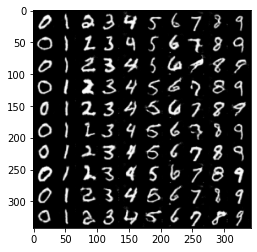

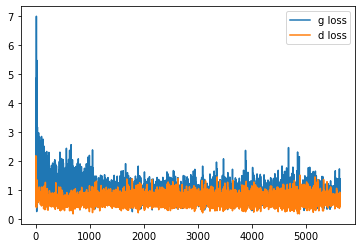

it: 3483; g_loss: 0.5643328428268433; d_loss: 1.1380101442337036; avg_real_score: 0.16224980354309082; avg_fake_score: 0.340012788772583: : 200it [01:22,  2.44it/s]

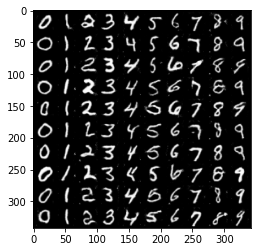

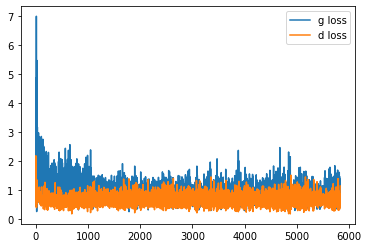

it: 3683; g_loss: 0.8001285791397095; d_loss: 0.7004751563072205; avg_real_score: 0.41584932804107666; avg_fake_score: 0.3955530822277069: : 400it [02:44,  2.45it/s]

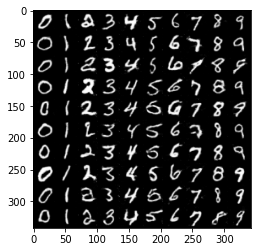

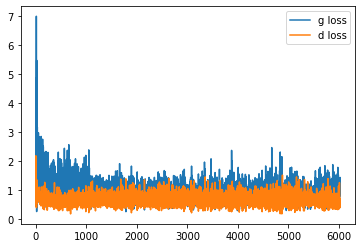

it: 3751; g_loss: 1.0531084537506104; d_loss: 0.6130778193473816; avg_real_score: 0.5174075365066528; avg_fake_score: 0.41441720724105835: : 469it [03:12,  2.44it/s]
it: 3752; g_loss: 0.7412209510803223; d_loss: 0.5796245336532593; avg_real_score: 0.46455055475234985; avg_fake_score: 0.2993992865085602: : 0it [00:00, ?it/s]

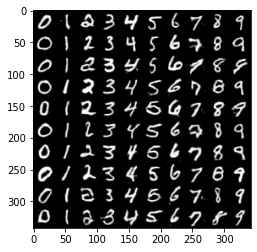

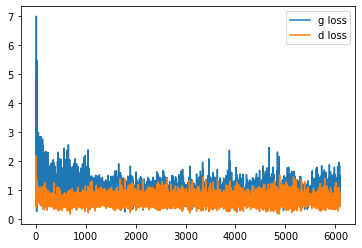

it: 3952; g_loss: 2.140857458114624; d_loss: 0.36286649107933044; avg_real_score: 0.8460210561752319; avg_fake_score: 0.4117295742034912: : 200it [01:22,  2.46it/s]

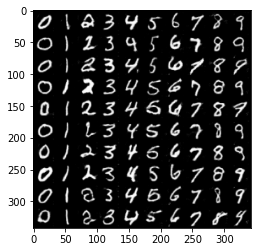

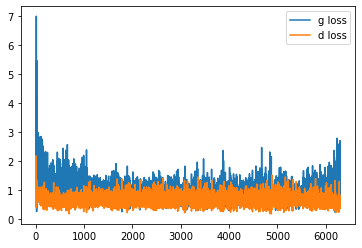

it: 4152; g_loss: 2.2758777141571045; d_loss: 0.43058377504348755; avg_real_score: 0.4924159646034241; avg_fake_score: 0.06220640242099762: : 400it [02:44,  2.47it/s]

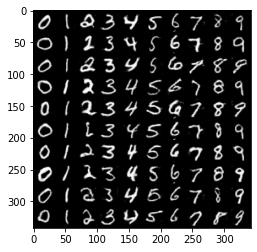

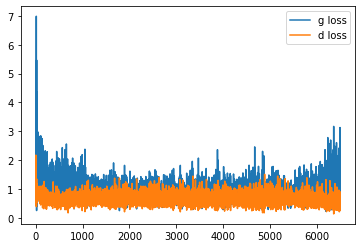

it: 4220; g_loss: 2.748072385787964; d_loss: 0.672309935092926; avg_real_score: 0.9600462913513184; avg_fake_score: 0.6941701769828796: : 469it [03:12,  2.44it/s]
it: 4221; g_loss: 2.259830951690674; d_loss: 0.36216115951538086; avg_real_score: 0.5599197149276733; avg_fake_score: 0.09576749801635742: : 0it [00:00, ?it/s]

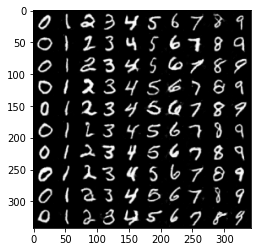

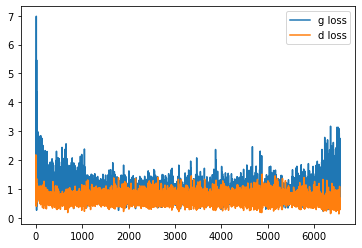

it: 4421; g_loss: 2.4925436973571777; d_loss: 0.2858712673187256; avg_real_score: 0.8949853181838989; avg_fake_score: 0.3391345739364624: : 200it [01:21,  2.49it/s]

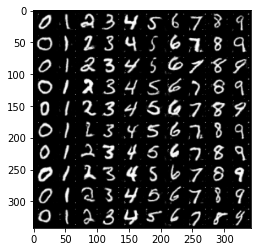

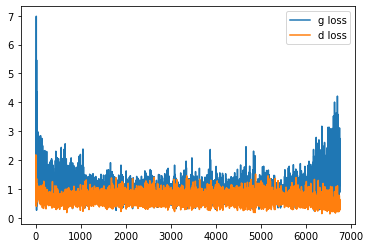

it: 4621; g_loss: 3.893336296081543; d_loss: 0.33401623368263245; avg_real_score: 0.9498328566551208; avg_fake_score: 0.40680694580078125: : 400it [02:42,  2.47it/s]

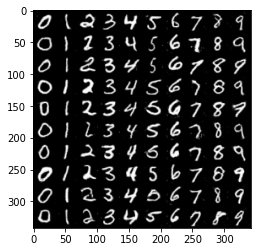

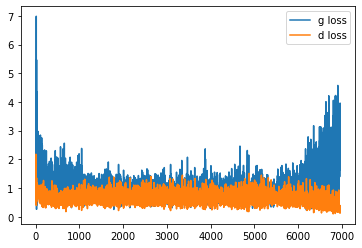

it: 4689; g_loss: 2.1790223121643066; d_loss: 0.21505390107631683; avg_real_score: 0.954278826713562; avg_fake_score: 0.2781839370727539: : 469it [03:10,  2.46it/s]


In [ ]:
nb_epochs = 10

g_losses = []
d_losses = []

j = 0

z_test = sample_z(100, nz)  # we generate the noise only once for testing Size->(100,nz)


for epoch in range(nb_epochs,2*nb_epochs):
    
    pbar = tqdm(enumerate(dataloader))
    for i, batch in pbar:
        im, labels = batch 
        im = im.to(device)
        cur_batch_size = im.shape[0]


        #Labels and Generated Labels
        y = F.one_hot(labels).float().to(device)
        gen_labels = F.one_hot(torch.randint(0,nc,[cur_batch_size])).float().to(device)  
        z=sample_z(cur_batch_size,nz)
        
        ###################
        #                 #
        # YOUR CODE HERE  #
        #                 #
        ###################
        zero_label= get_labels_zero(cur_batch_size)# Size-> (cur_batch_size,1)
        one_label=get_labels_one(cur_batch_size)# Size-> (cur_batch_size,1)
        
        # 2. Generate a fake image
        fake_image=netG(z,gen_labels)

        # 3. Classify real image with D
        yhat_real=netD(im,y)
        real_loss=criterion(yhat_real,one_label)

        # 4. Classify fake image with D
        yhat_fake=netD(fake_image.detach(),gen_labels)
        fake_loss=criterion(yhat_fake,zero_label)
        
        ###
        ### Discriminator
        ###
        
        d_loss =(real_loss+fake_loss)/2 #     YOUR CODE HERE
        d_opt.zero_grad()
        d_loss.backward() # we need to retain graph=True to be able to calculate the gradient in the g backprop
        d_opt.step()

        
        ###
        ### Generator
        ###
    
        
        g_loss = criterion(netD(fake_image,gen_labels),one_label) #      YOUR CODE HERE
        g_opt.zero_grad()
        g_loss.backward()
        g_opt.step()
        
        
        # Save Metrics
        
        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())
        
        avg_real_score = yhat_real.mean().item()
        avg_fake_score = yhat_fake.mean().item()

        pbar.set_description(f"it: {j}; g_loss: {g_loss}; d_loss: {d_loss}; avg_real_score: {avg_real_score}; avg_fake_score: {avg_fake_score}")
        
        if i % display_freq == 0:
            labels = torch.arange(0, 10).expand(size=(10, 10)).flatten().to(device)
            y = F.one_hot(labels).float().to(device)
            fake_im = netG(z_test, y)
            
            un_norm = renorm(fake_im) # for visualization
            
            grid = torchvision.utils.make_grid(un_norm, nrow=10)
            pil_grid = to_pil(grid)  
            
            plt.imshow(pil_grid)
            plt.show()
            
            
            plt.plot(range(len(g_losses)), g_losses, label='g loss')
            plt.plot(range(len(g_losses)), d_losses, label='d loss')
            
            plt.legend()
            plt.show()
            
        j += 1